# OOI RCA 2024 DAS -- Event Denoising and Detection

**Author:** Qibin Shi (qs20@rice.edu; qibin.nan@gmail.com)

**Last updated:** Dec 7, 2025

This notebook provides a demo on processing the data from the Ocean Observatories Initiative (OOI) 

Regional Cabled Array's Distributed Acoustic Sensing (DAS) to detect regional earthquakes.

## Overview

The data for this experiment was acquired using the OptoDAS system from Alcatel Subsea Networks. 

The focus was on the South Cable of the OOI RCA.

## Data Access (not for this tutorial)

The complete OptoDAS data can be accessed via the following link:

[OptoDAS Data Repository](http://piweb.ooirsn.uw.edu/das24/data/)

The data is organized into directories named by date. Here’s a breakdown:

- **200G**: 2024-05-06
- **617G**: 2024-05-07
- **617G**: 2024-05-08
- **617G**: 2024-05-09
- **382G**: 2024-05-10

For details on how to read and manipulate the HDF5 format data, refer to the

 [example code in this repository](https://github.com/uwfiberlab/OOI_DAS_2024).

## Cable Geometry

The map shows the OOI RCA cables (black lines) and the interrogated segment (red line) 

between the Oregon coast and the repeater (red dots). Bathymetric contours are in meters. 

The inset map indicates full-length cables, seafloor nodes, coastal lines, and plate boundaries.

![<img src="./utils_for_denodas/fig-OOIcable.jpg" width="600">](https://github.com/uwfiberlab/sz4d_das_workshop/blob/main/notebooks/qibin/utils_for_denodas/fig-OOIcable.jpg?raw=true)

In [ ]:
import warnings
warnings.filterwarnings('ignore')
import os
import gc

import sys
sys.path.append('./utils_for_denodas/')

import h5py
import numpy as np

import torch
import torch.nn as nn
import seisbench.models as sbm

from das_util import *
from denodas_model import unet
from scipy.signal import filtfilt, butter, decimate
from scipy.interpolate import interp1d

import obspy
from obspy import UTCDateTime
from obspy.clients.fdsn import Client

import matplotlib
from matplotlib import pyplot as plt
matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['font.sans-serif'] = ['DejaVu Sans']
matplotlib.rcParams['font.size'] = 22

import psutil, os
proc = psutil.Process(os.getpid())
print(f"RSS GB: {proc.memory_info().rss/1e9:.2f}")

### Directory for data and denoising model
rawdata_dir = '/1-fnp/petasaur/p-wd02/muxDAS/'
rawdata_dir = '../../data/qibin/'
model_dir = './utils_for_denodas/denoiser_weights_LR08_MASK05_raw2raw_old.pt'
data_picked =  False

RSS GB: 0.52


## Metadata of 2024 OOI DAS

Select a file to extract metadata

In [ ]:
# fname = os.path.join(rawdata_dir, '20240510/dphi/024905.hdf5')
fname = os.path.join(rawdata_dir, '024905.hdf5')

gl, t0, dt, fs, dx, un, ns, nx = extract_metadata(fname, machine_name='optodas')

t0 = UTCDateTime(t0)

print('Start time:\t\t\t', t0)
print('Unit:\t\t\t\t',un.decode('UTF-8'))
print('Gauge length (m):\t\t', gl)
print('Sampling rate (Hz):\t\t',fs)
print('Sample interval (s):\t\t',dt)
print('Channel interval (m):\t\t',dx)
print('Number of samples:\t\t',ns)
print('Number of channels:\t\t',nx)

Start time:			 2024-05-10T02:49:05.302000Z
Unit:				 rad/(s*m)
Gauge length (m):		 40.85200763098726
Sampling rate (Hz):		 200.0
Sample interval (s):		 0.005
Channel interval (m):		 10.213001907746815
Number of samples:		 2000
Number of channels:		 9500


Visualize the cable coordinate

Text(0, 0.5, 'Latitude')

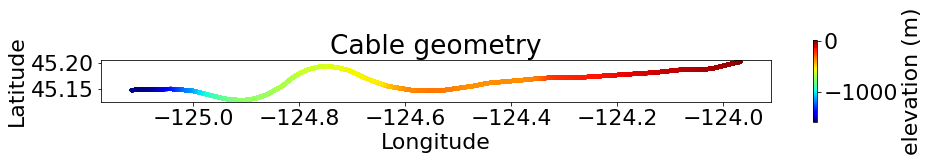

In [3]:
### Get the cable latitude, longitude, and depth
cable = np.genfromtxt('./utils_for_denodas/south_DAS_latlondepth.txt')
lat = cable[:,1]
lon = cable[:,2]
dep = cable[:,3]

### Plot cable geometry
plt.figure(figsize=(15, 1.5))
cb = plt.scatter(lon, lat, c=dep, marker='.', cmap='jet')
plt.colorbar(cb, label='elevation (m)', aspect=20)
plt.gca().set_aspect('equal')
plt.title('Cable geometry')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

## DAS data processing

Select a starting time that match the saved data.

In [ ]:
imin = '0249'

# imin = '1338'
# imin = '0956'

Read one-minute data

In [5]:
### A list of suffixes presenting starting seconds
### of each 10-second file
files = ['05', '15', '25', '35', '45', '55']

### Read this six files and concatenate to form one 60-second data
### 9000 channels starting from ch 500 (5km) to avoid onshore cable part
### 2000 samples for each 10-second file at 200 Hz sampling rate
minute_data = np.zeros((9000, 12000), dtype=np.float32)
st_pt = 0

for k in range(len(files)): 

    fname = os.path.join(rawdata_dir, imin+files[k]+'.hdf5')
    with h5py.File(fname, 'r') as f:

        time_data =f['data'][:2000, 500:9500]

    minute_data[:time_data.shape[1], st_pt:st_pt+time_data.shape[0]] = time_data.T

    st_pt += time_data.shape[0]

    ### delete time_data to free memory
    del time_data
    gc.collect()

d_st = dx * 500 /1000 - 1.860  # distance shift due to starting from ch 500
### print the shape of the concatenated data
print('Data shape (channels, time points):', minute_data.shape)
print('Distance shift (km):\t\t', d_st)

Data shape (channels, time points): (9000, 12000)
Distance shift (km):		 3.246500953873407


Downsample channels by 6 and time points by 8.

Reduced resolution is 61 m x 0.04 s, sufficient for regional earthquakes

In [6]:
### Decimate data to reduce computational cost
tmp = decimate(minute_data,8)
tmp = decimate(tmp,6, axis=0)

### time and distance intervals after decimation
dt_new = dt * 8
dx_new = dx * 6
nx = tmp.shape[0]
nt = tmp.shape[1]

### time and distance axes after decimation
t_ax = np.arange(nt)*dt_new + int(files[0])
d_ax = np.arange(nx)*dx_new/1000 + d_st

### print updated metadata
print('\nAfter decimation:')
print('New sample interval (s):\t',dt_new)
print('New channel interval (m):\t',dx_new)
print('New number of channels:\t\t',nx)
print('New number of samples:\t\t',nt)

### delete large variables to free memory
del minute_data
gc.collect()


After decimation:
New sample interval (s):	 0.04
New channel interval (m):	 61.27801144648089
New number of channels:		 1500
New number of samples:		 1500


0

Bandpass filter to 1-6 Hz

This removes ocean waves < 1 Hz and instrument noise > 6 Hz

In [7]:
b, a = butter(4, (1, 6), fs=25, btype='bandpass')
filt = filtfilt(b, a, tmp, axis=1)
filtered_data = filt - np.mean(filt, axis=(0,1), keepdims=True)


### check memory usage
del filt
gc.collect()
proc = psutil.Process(os.getpid())
print(f"RSS GB: {proc.memory_info().rss/1e9:.2f}")

RSS GB: 0.63


Visualize the raw and filtered data

Text(0, 0.5, 'Latitude')

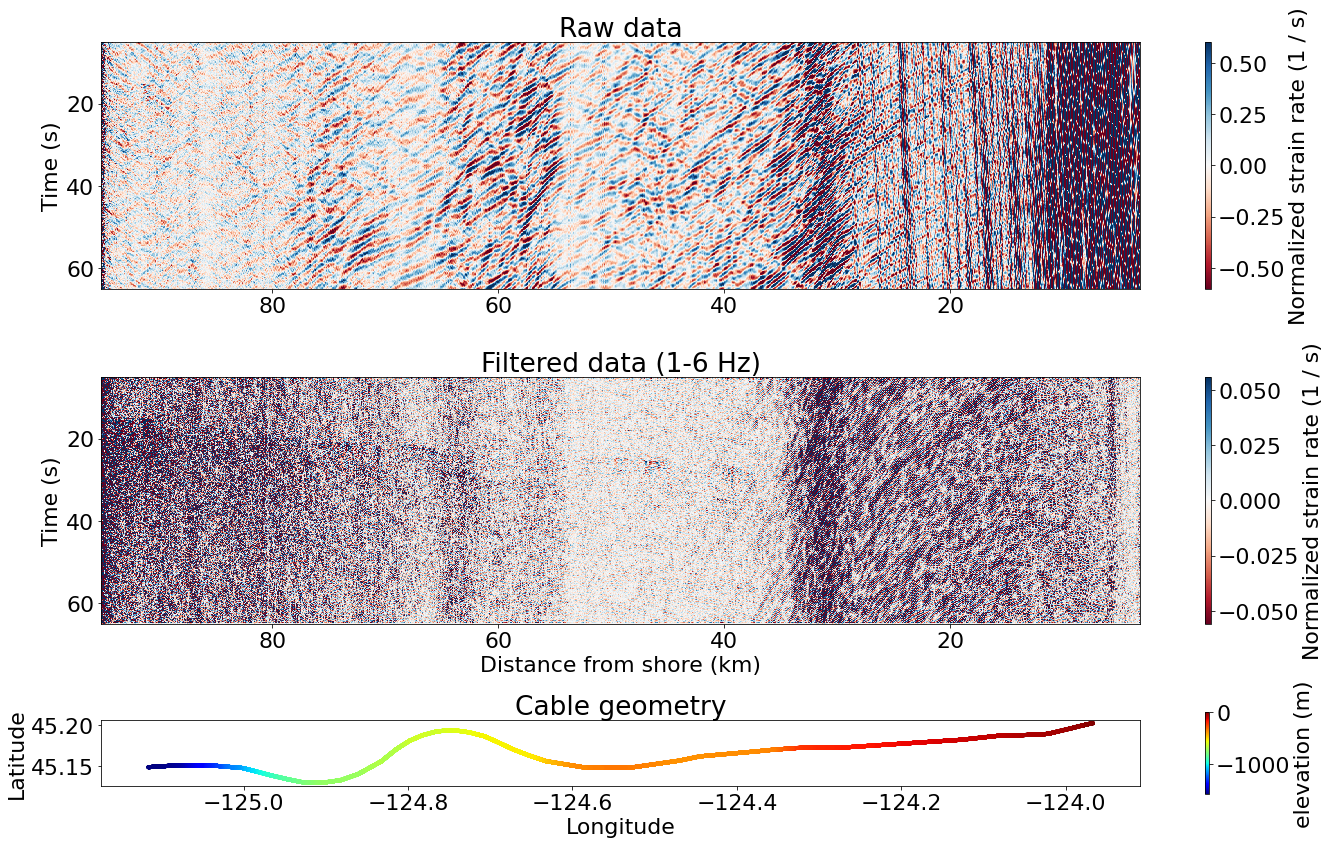

In [8]:
### Figure size and height partition
fig, ax = plt.subplots(3, 1, figsize=(20, 12), tight_layout=True, 
                       gridspec_kw={'height_ratios': [3, 3, 1]})

### Plot the raw data
im = ax[0].pcolor(d_ax, t_ax, tmp.T, cmap='RdBu',
                  vmin=-np.std(tmp), vmax=np.std(tmp),
                  shading='auto', rasterized=True)
fig.colorbar(im, ax=ax[0], aspect=40, label='Normalized strain rate (1 / s)')
ax[0].set_ylabel('Time (s)')
ax[0].invert_xaxis()
ax[0].invert_yaxis()
ax[0].set_title('Raw data')

### Plot the filtered data
im = ax[1].pcolor(d_ax, t_ax, filtered_data.T, cmap='RdBu',
                  vmin=-np.std(filtered_data), vmax=np.std(filtered_data),
                  shading='auto', rasterized=True)
fig.colorbar(im, ax=ax[1], aspect=40, label='Normalized strain rate (1 / s)')
ax[1].set_xlabel('Distance from shore (km)')
ax[1].set_ylabel('Time (s)')
ax[1].invert_xaxis()
ax[1].invert_yaxis()
ax[1].set_title('Filtered data (1-6 Hz)')

### Plot cable geometry
cb = ax[2].scatter(lon, lat, c=dep, marker='.', cmap='jet')
fig.colorbar(cb, ax=ax[2], label='elevation (m)', aspect=20)
ax[2].set_aspect('equal')
ax[2].set_title('Cable geometry')
ax[2].set_xlabel('Longitude')
ax[2].set_ylabel('Latitude')

In [9]:
fig.clf()
plt.close()
del fig, ax, im, cb
gc.collect()

### check memory usage
proc = psutil.Process(os.getpid())
print(f"RSS GB: {proc.memory_info().rss/1e9:.2f}")

RSS GB: 1.05


## DAS denoising

Prepare the denoising model

In [29]:
### Initialize the U-net
devc = torch.device('cpu')
model_1 = unet(1, 16, 1024, factors=(5, 3, 2, 2), use_att=False)
model_1.to(devc)

### Convert multi-GPU trained model to single-CPU model
state_dict = torch.load(model_dir, map_location=torch.device('cpu'))
new_state_dict = {}
for k, v in state_dict.items():
    new_k = k.replace("module.", "")   # remove prefix
    new_state_dict[new_k] = v

### Load the pretrained weights
model_1.load_state_dict(new_state_dict)
model_1.eval() 

unet(
  (relu): ReLU()
  (layer): ModuleList(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (2): MaxBlurPool2d()
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): MaxBlurPool2d()
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): MaxBlurPool2d()
    (9): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): Dropout(p=0.2, inplace=False)
    (12): MaxBlurPool2d()
    (13): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): Dropout(p=0.2, inplace=False)
    (16): Upsa

Apply denoising model

In [11]:
### Denoising
one_denoised, mul_denoised = Denoise_largeDAS(filtered_data/np.std(filtered_data, axis=(0,1), keepdims=True), 
                                                model_1, devc, repeat=4, norm_batch=False)

### Normalize the denoised data
mul_denoised = (mul_denoised-np.mean(mul_denoised, axis=(0,1), keepdims=True)) * np.std(mul_denoised, axis=(0,1), keepdims=True)

### Bandpass filter
b, a = butter(4, (1, 6), fs=25, btype='bandpass')
filt = filtfilt(b, a, mul_denoised, axis=1)
mul_denoised = filt - np.mean(filt, axis=(0,1), keepdims=True)

### check memory usage
del filt, one_denoised
gc.collect()
proc = psutil.Process(os.getpid())
print(f"RSS GB: {proc.memory_info().rss/1e9:.2f}")

torch.Size([1, 1500, 1500])
RSS GB: 1.18


## Phase picking

Use ELEP (Yuan et al., 2024) to pick seismo-acoustic phases

Load the picker

In [12]:
### ML picker parameters
paras_semblance = {'dt':0.01, 
                   'semblance_order':2, 
                   'window_flag':True, 
                   'semblance_win':0.5, 
                   'weight_flag':'max'}

### Download models
devcc = torch.device('cpu')

pn_ethz_model = sbm.EQTransformer.from_pretrained("ethz")
pn_instance_model = sbm.EQTransformer.from_pretrained("instance")
pn_scedc_model = sbm.EQTransformer.from_pretrained("scedc")
pn_stead_model = sbm.EQTransformer.from_pretrained("stead")
pn_geofon_model = sbm.EQTransformer.from_pretrained("geofon")
pn_neic_model = sbm.EQTransformer.from_pretrained("neic")

pn_ethz_model.to(devcc)
pn_scedc_model.to(devcc)
pn_neic_model.to(devcc)
pn_geofon_model.to(devcc)
pn_stead_model.to(devcc)
pn_instance_model.to(devcc)

list_models = [pn_ethz_model,pn_scedc_model,pn_neic_model,
               pn_geofon_model,pn_stead_model,pn_instance_model]

Interpolate along the time axis for picking

In [13]:
### The phase picker needs 6000 time points as input
interp_func = interp1d(np.linspace(0, 1, 1500), 
                       filtered_data/np.std(filtered_data), 
                       axis=-1, kind='linear')
interpolated_image = interp_func(np.linspace(0, 1, 6000))

interp_func = interp1d(np.linspace(0, 1, 1500), 
                       mul_denoised/np.std(mul_denoised), 
                       axis=-1, kind='linear')
interpolated_muldenoised = interp_func(np.linspace(0, 1, 6000))

Apply picker on interpolated data

In [ ]:
### Pick RAW data， every 2 channels
print('Start picking raw data ...')
image1 = np.nan_to_num(interpolated_image[::2,:])
raw_picks = apply_elep(image1, list_models, 100, paras_semblance, devcc)
print('Finished picking raw data.')

### Pick mulDENOISED, every 2 channels
print('Start picking denoised data ...')
image2 = np.nan_to_num(interpolated_muldenoised[::2,:])
mul_picks = apply_elep(image2, list_models, 100, paras_semblance, devcc)
print('Finished picking denoised data.')

data_picked =  True

### check memory usage
del interpolated_image, interpolated_muldenoised, image1, image2, \
pn_ethz_model, pn_scedc_model, pn_neic_model, \
pn_geofon_model, pn_stead_model, pn_instance_model, model_1
gc.collect()
proc = psutil.Process(os.getpid())
print(f"RSS GB: {proc.memory_info().rss/1e9:.2f}")

RSS GB: 1.18


## Compare raw and denoised earthquake signals and phase picks

First, set space and time range to zoom in the signal

In [ ]:
### Specify the distance range and time range for plotting
d1_trimed = 30 # km
d2_trimed = 95 # km

t1_trimed = 12 # s
t2_trimed = 32 # s

d1_trimed_idx = int((d1_trimed - d_st) * 1000 / dx_new)
d2_trimed_idx = int((d2_trimed - d_st) * 1000 / dx_new)
t1_trimed_idx = int((t1_trimed - int(files[0])) / dt_new)
t2_trimed_idx = int((t2_trimed - int(files[0])) / dt_new)

### Trim data for visualization
rawdata = filtered_data[d1_trimed_idx:d2_trimed_idx, t1_trimed_idx:t2_trimed_idx]
denoised = mul_denoised[d1_trimed_idx:d2_trimed_idx, t1_trimed_idx:t2_trimed_idx]

### update nx, nt, t_ax, d_ax
nx_trimed = rawdata.shape[0]
nt_trimed = rawdata.shape[1]

t_ax_trimed = t_ax[t1_trimed_idx:t2_trimed_idx]
d_ax_trimed = d_ax[d1_trimed_idx:d2_trimed_idx]

### Normalize trimmed data along time axis
rawdata = (rawdata - np.mean(rawdata, axis=1, keepdims=True))/np.std(rawdata, axis=1, keepdims=True)
denoised = (denoised - np.mean(denoised, axis=1, keepdims=True))/np.std(denoised, axis=1, keepdims=True)

if data_picked:
    raw_picks_trimed = raw_picks[d1_trimed_idx//2:d2_trimed_idx//2, :, :]
    mul_picks_trimed = mul_picks[d1_trimed_idx//2:d2_trimed_idx//2, :, :]

### check memory usage
del raw_picks, mul_picks, filtered_data, mul_denoised
gc.collect()
proc = psutil.Process(os.getpid())
print(f"RSS GB: {proc.memory_info().rss/1e9:.2f}")

RSS GB: 1.18


Plot the trimmed DAS data

number of good picks on raw data:  25
number of good picks after denoising:  141


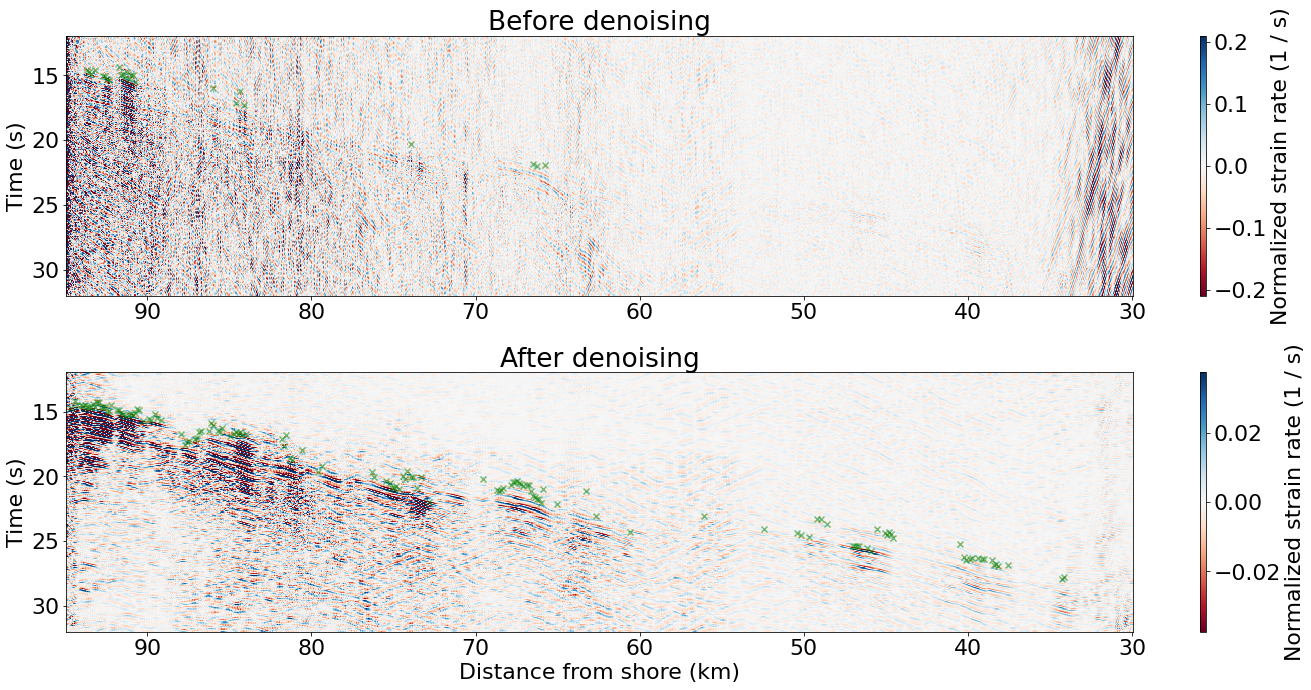

In [16]:
### Figure size
fig, ax = plt.subplots(2, 1, figsize=(20, 10), tight_layout=True)

### Plot the raw data
im = ax[0].pcolor(d_ax_trimed, t_ax_trimed, rawdata.T, cmap='RdBu',
                  vmin=-np.std(rawdata)*4, vmax=np.std(rawdata)*4,
                  shading='auto', rasterized=True)
fig.colorbar(im, ax=ax[0], aspect=40, label='Normalized strain rate (1 / s)')

ax[0].set_ylabel('Time (s)')
ax[0].invert_xaxis()
ax[0].invert_yaxis()
ax[0].set_title('Before denoising')

### Plot the denoised data
im = ax[1].pcolor(d_ax_trimed, t_ax_trimed, denoised.T, cmap='RdBu',
                  vmin=-np.std(denoised)*4, vmax=np.std(denoised)*4,
                  shading='auto', rasterized=True)
fig.colorbar(im, ax=ax[1], aspect=40, label='Normalized strain rate (1 / s)')

ax[1].set_xlabel('Distance from shore (km)')
ax[1].set_ylabel('Time (s)')
ax[1].invert_xaxis()
ax[1].invert_yaxis()
ax[1].set_title('After denoising')

### Overlay picks
if data_picked:
    ind_good = np.where(raw_picks_trimed[:,1,1]>0.07)[0]
    print("number of good picks on raw data: ",len(ind_good))
    ax[0].scatter(d_ax_trimed[ind_good*2], raw_picks_trimed[ind_good,1,0]+5,c='g', marker='x', alpha=0.5)

    ind_good = np.where(mul_picks_trimed[:,1,1]>0.07)[0]
    print("number of good picks after denoising: ",len(ind_good))
    ax[1].scatter(d_ax_trimed[ind_good*2], mul_picks_trimed[ind_good,1,0]+5, c='g', marker='x', alpha=0.5)

In [17]:
## clear all variables to free memory
del rawdata, denoised, raw_picks_trimed, mul_picks_trimed
gc.collect()

fig.clf()
plt.close()
del fig, ax, im
gc.collect()

### check memory usage
proc = psutil.Process(os.getpid())
print(f"RSS GB: {proc.memory_info().rss/1e9:.2f}")

RSS GB: 1.18


## Check OBS for this event

First, get a list of regional OBS

In [18]:
client = Client("IRIS")
t1 = UTCDateTime("2024-05-06")
t2 = UTCDateTime("2024-05-10")

inventory = client.get_stations(network="OO", channel="?H?",
                                starttime=t1, endtime=t2, 
                                maxlatitude=46.947, minlatitude=43.437, 
                                maxlongitude=-123.6621, minlongitude=-129.6803)

inventory

Inventory created at 2025-12-10T01:47:20.318900Z
	Created by: IRIS WEB SERVICE: fdsnws-station | version: 1.1.52
		    http://service.iris.edu/fdsnws/station/1/query?starttime=2024-05-06...
	Sending institution: IRIS-DMC (IRIS-DMC)
	Contains:
		Networks (1):
			OO
		Stations (5):
			OO.HYS11 (RSN Hydrate Summit 1-1)
			OO.HYS12 (RSN Hydrate Summit 1-2)
			OO.HYS13 (RSN Hydrate Summit 1-3)
			OO.HYS14 (RSN Hydrate Summit 1-4)
			OO.HYSB1 (RSN Hydrate Slope Base)
		Channels (0):


Specify starting time to download seismic network data

In [19]:
t1 = UTCDateTime("2024-05-10T02:48:10")
# t1 = UTCDateTime("2024-05-08T13:37:00")

Loop over all stations to visualize waveforms

--- Downloading data for OO.HYS11 on 2024-05-10T02:48:10.000000Z ---
--- Resampled 100 Hz for OO.HYS11 on 2024-05-10T02:48:10.000000Z ---
--- Merging data for OO.HYS11 on 2024-05-10T02:48:10.000000Z ---
--- Aligning data for OO.HYS11 on 2024-05-10T02:48:10.000000Z ---


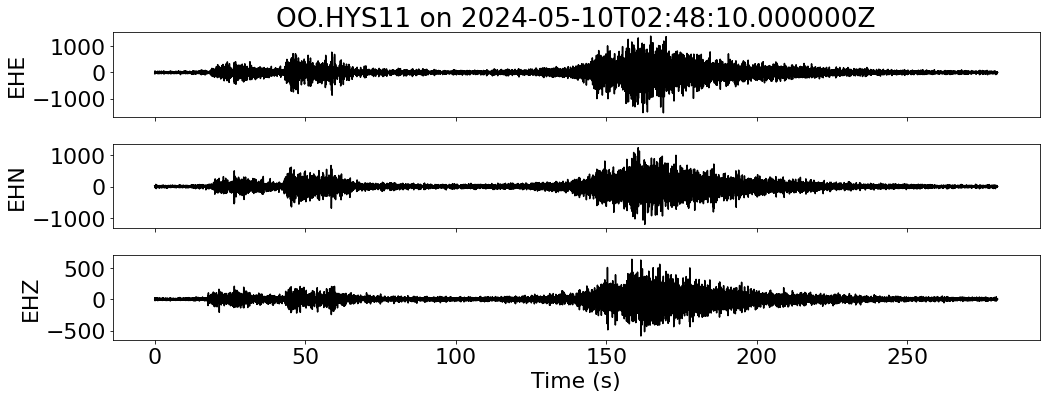

RSS GB: 1.19
--- Downloading data for OO.HYS12 on 2024-05-10T02:48:10.000000Z ---
--- Resampled 100 Hz for OO.HYS12 on 2024-05-10T02:48:10.000000Z ---
--- Merging data for OO.HYS12 on 2024-05-10T02:48:10.000000Z ---
--- Aligning data for OO.HYS12 on 2024-05-10T02:48:10.000000Z ---


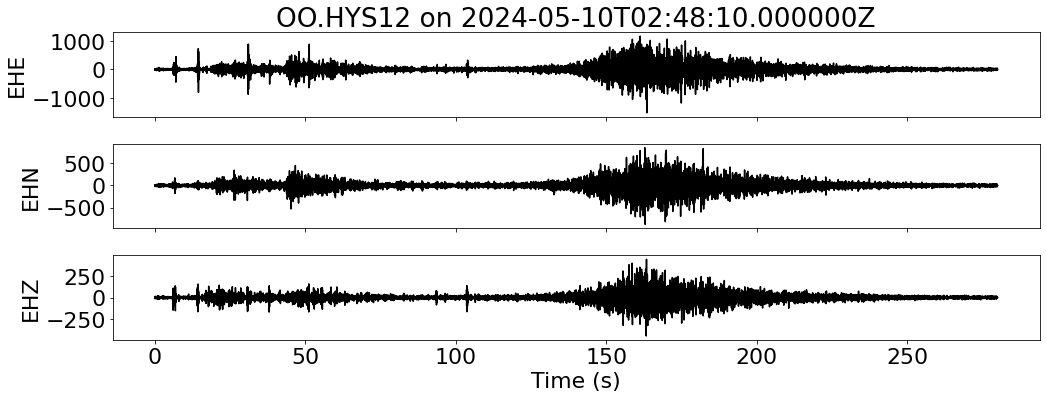

RSS GB: 1.19
--- Downloading data for OO.HYS13 on 2024-05-10T02:48:10.000000Z ---
--- Resampled 100 Hz for OO.HYS13 on 2024-05-10T02:48:10.000000Z ---
--- Merging data for OO.HYS13 on 2024-05-10T02:48:10.000000Z ---
--- Aligning data for OO.HYS13 on 2024-05-10T02:48:10.000000Z ---


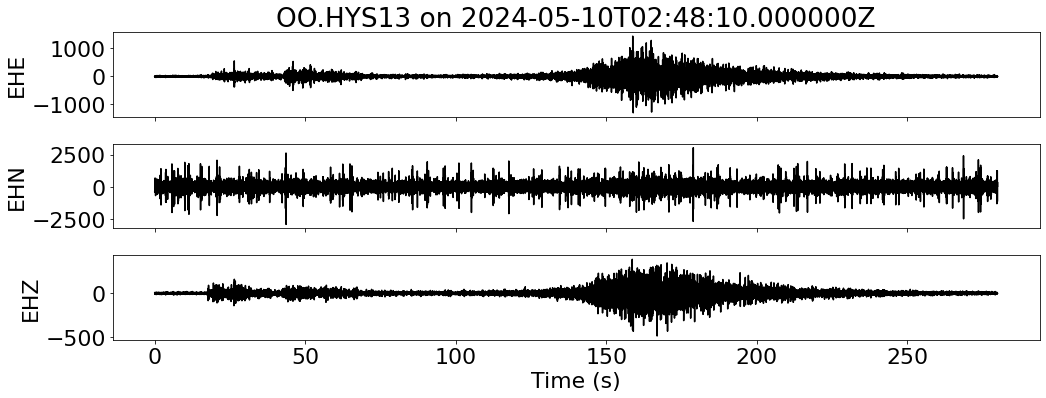

RSS GB: 1.19
--- Downloading data for OO.HYS14 on 2024-05-10T02:48:10.000000Z ---
--- Merging data for OO.HYS14 on 2024-05-10T02:48:10.000000Z ---
--- Aligning data for OO.HYS14 on 2024-05-10T02:48:10.000000Z ---


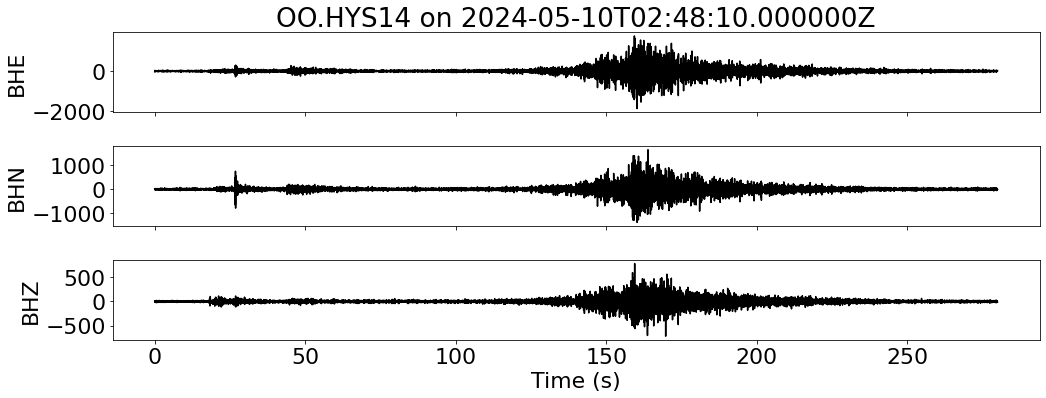

RSS GB: 1.19
--- Downloading data for OO.HYSB1 on 2024-05-10T02:48:10.000000Z ---
--- No data for OO.HYSB1 on 2024-05-10T02:48:10.000000Z ---


In [20]:
for net in inventory:
    network = net.code

    for sta in net:
        station = sta.code
        latitude = sta.latitude
        longitude = sta.longitude
        elevation = sta.elevation
        
        ### Download waveform data
        print(f"--- Downloading data for {network}.{station} on {t1} ---")
        try:
            sdata = Client("IRIS").get_waveforms(network=network, 
                                            station=station,
                                            location="*", 
                                            channel="BH?,EH?", 
                                            starttime=t1+0,
                                            endtime=t1 + 290)
            
        except obspy.clients.fdsn.header.FDSNNoDataException:
            print(f"--- No data for {network}.{station} on {t1} ---")
            continue

        ### Check sampling rates and resample if needed
        fs_all = [tr.stats.sampling_rate for tr in sdata]
        fs = np.round(fs_all[0])
        if fs > 100:
            sdata = sdata.resample(100)
            print(f"--- Resampled {100} Hz for {network}.{station} on {t1} ---")
        elif len(np.unique(np.array(fs_all))) > 1:      
            print(f"--- Sampling rates are different for {network}.{station} on {t1} ---")
            sdata = sdata.resample(fs)
            print(f"--- Resampled {fs} Hz for {network}.{station} on {t1} ---")

        ### Merge, filter, and align data
        print(f"--- Merging data for {network}.{station} on {t1} ---")
        sdata.merge(fill_value='interpolate')  # fill gaps
        sdata.filter("bandpass", freqmin=3, freqmax=20, corners=4, zerophase=True) 
        btime = sdata[0].stats.starttime

        print(f"--- Aligning data for {network}.{station} on {t1} ---")
        # align 3 components
        max_b = max([tr.stats.starttime for tr in sdata])
        min_e = min([tr.stats.endtime for tr in sdata])
        for tr in sdata:
            tr.trim(starttime=max_b+10, endtime=min_e, nearest_sample=True)  

        ### Plot waveforms 
        fig, ax = plt.subplots(len(sdata), 1, figsize=(15, 6), sharex=True)
        for i, tr in enumerate(sdata):
            ax[i].plot(tr.times("relative"), tr.data, "k")
            ax[i].set_ylabel(f"{tr.stats.channel}")
   
        ax[-1].set_xlabel("Time (s)")
        ax[0].set_title(f"{network}.{station} on {t1}")
    
        plt.tight_layout()
        plt.show()

        del sdata
        gc.collect()

        fig.clf()
        plt.close()
        del fig, ax
        gc.collect()

        ### check memory usage
        proc = psutil.Process(os.getpid())
        print(f"RSS GB: {proc.memory_info().rss/1e9:.2f}")

In [21]:
### check memory usage
proc = psutil.Process(os.getpid())
print(f"RSS GB: {proc.memory_info().rss/1e9:.2f}")

RSS GB: 1.19


## What next?
![<img src="./utils_for_denodas/locations.png" width=10>](https://github.com/uwfiberlab/sz4d_das_workshop/blob/main/notebooks/qibin/utils_for_denodas/locations.png?raw=true)

## Reference

- Self-supervised machine learing for DAS: https://github.com/Denolle-Lab/Shi_etal_2023_denoiseDAS
- Shi, Q., Williams, E. F., Lipovsky, B. P., Denolle, M. A., Wilcock, W. S., Kelley, D. S., & Schoedl, K. (2025). Multiplexed distributed acoustic sensing offshore central Oregon. Seismological Research Letters, 96(2A), 784-800.
- Shi, Q., Denolle, M. A., Ni, Y., Williams, E. F., & You, N. (2025). Denoising offshore distributed acoustic sensing using masked auto‐encoders to enhance earthquake detection. Journal of Geophysical Research: Solid Earth, 130(2), e2024JB029728.